# Tutorial 2: Spectral class

The ```measpy.Spectral``` class represents signals in the Fourier space

An object of the ```Spectral``` class has the following main properties:
- ```fs``` : a sampling frequency (int)
- ```desc``` : a description (string)
- ```unit``` : a physical unit (unyt.unit)
- ```values``` : a 1D array (float) containing the values of the Fourier spectrum
- ```full``` : a boolean value indicating if the spectrum values are given up to the sampling frequency ```fs``` or the Nyquist frequency ```fs/2``` 

In [1]:
#This is here in case we want to use the local measy directory
import sys
sys.path.insert(0, "..")

import measpy as mp
import numpy as np
import matplotlib.pyplot as plt

Let us create a white noise signal of duration 5 seconds, with the sampling frequency ```fs```=44100 Hz

measpy.Signal(fs=44100,
desc='Noise 0-22050Hz',
freq_min=0,
freq_max=22050,
_rawvalues=[ 2.63749506  1.21468672 -0.39634116 ...  0.90318963  1.48549855
  0.64043848],
)


<Axes: xlabel='Time (s)'>

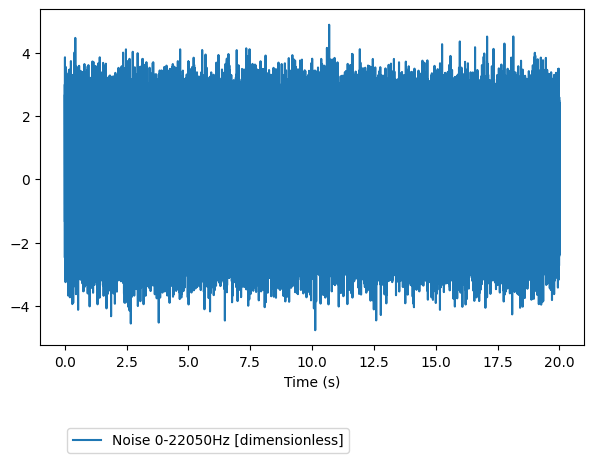

In [2]:
noise = mp.Signal.noise(freq_min=0,freq_max=22050,fs=44100,dur=20)
print(noise)
noise.plot()

Let us now filter this noise using the method ```Signal.iir```, which is basically a wrapper function around ```scipy.signal.filter.iirfilter``` and ```scipy.signal.filter.sosfilt```.

Below, the white noise is filtered above 1000Hz using a 6th-order butterworth filter (default type)

In [3]:
noisef = noise.iir(N=2,Wn=1000,btype='lowpass',ftype='butter')

We now calculate and plot the FFT

As the signal is real valued, it is fair to use the rfft, which only returns the (complex) values of the FFT up to the Nyquist frequency.

rfft is a method of ```measpy.Signal``` class, that returns an object of the ```measpy.Spectral``` class

By default, with no arguments, the plot method of the ```Spectral``` class plots the dB amplitude (ref. unity) and phase, with logarithmic frequency scale, and returns an array of two axes.

measpy.Spectral(_values=[-4.15815877e+00+0.00000000e+00j  8.68094334e+02+3.48103038e+02j
 -9.17516659e+02-2.18577396e+02j ... -1.18209042e-01+9.07961848e-07j
 -1.18209042e-01+4.54029362e-07j -1.18209042e-01+0.00000000e+00j],
desc='Noise 0-22050Hz
 -->filtered
 -->RFFT',
fs=44100,
full=False,
norm='backward',
odd=False,
)


array([<Axes: xlabel='Freq (Hz)', ylabel='20 Log |H|'>,
       <Axes: xlabel='Freq (Hz)', ylabel='Phase'>], dtype=object)

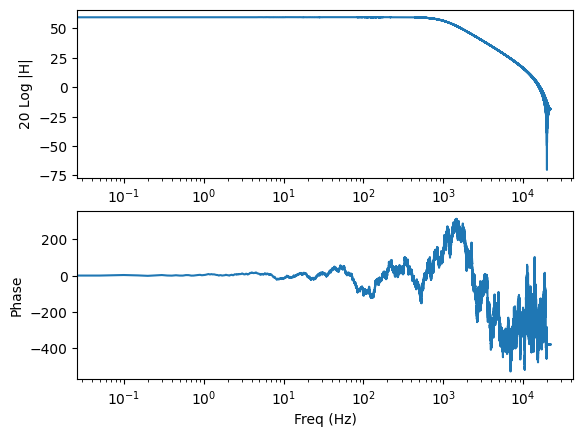

In [4]:
noisesp = noisef.rfft()
print(noisesp)
noisesp.plot()

The ```measpy.Spectral.irfft``` method allows to go back the time domain...

<Axes: xlabel='Time (s)'>

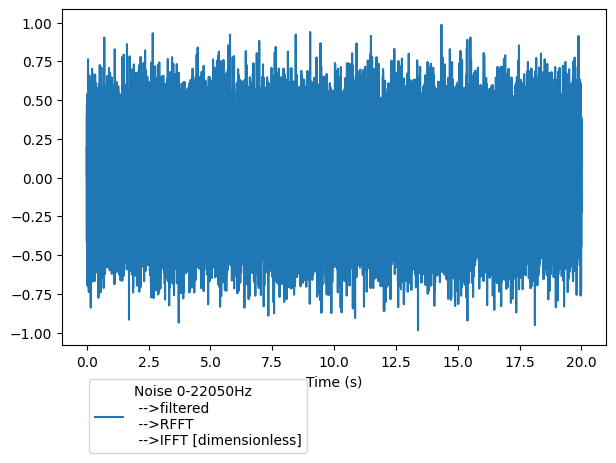

In [5]:
noisesp.irfft().plot()

To compute the frequency response of the filter, we can use Welch's method for transfer function estimation.

Let us do this and compare with the analytical frequency response given by ```scipy.signal.sosfreqz```

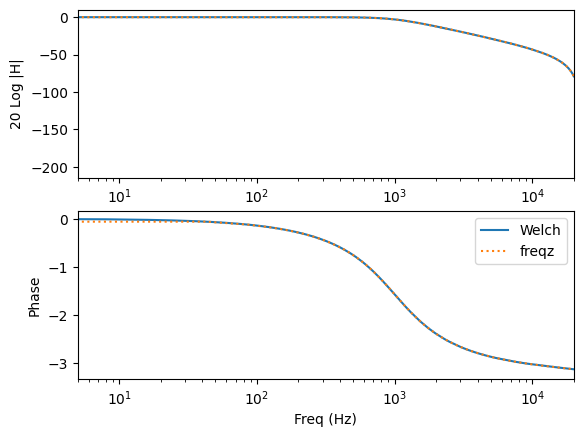

In [6]:
sp = noisef.tfe_welch(noise,nperseg=2**14)
ax = sp.plot(label='Welch')

from scipy.signal import iirfilter, sosfreqz

sos = iirfilter(N=2,Wn=1000,btype='lowpass',fs=noise.fs,output='sos',ftype='butter')
f,h = sosfreqz(sos,fs=noise.fs)
ax[0].plot(f,20*np.log10(abs(h)),label='freqz',ls=':')
ax[0].set_xlim([5,20000])
ax[1].plot(f,np.unwrap(np.angle(h)),label='freqz',ls=':')
ax[1].set_xlim([5,20000])
ax[1].legend()


## Units

Units are preserved during all the spectral/signal analyses.

To illustrate this, let us create a noise signal, in Volts, and another one in Pascals, and do some Fourier analyses with these signals.

Unit of v_fft is V
Unit of p_fft is Pa


(20, 20000)

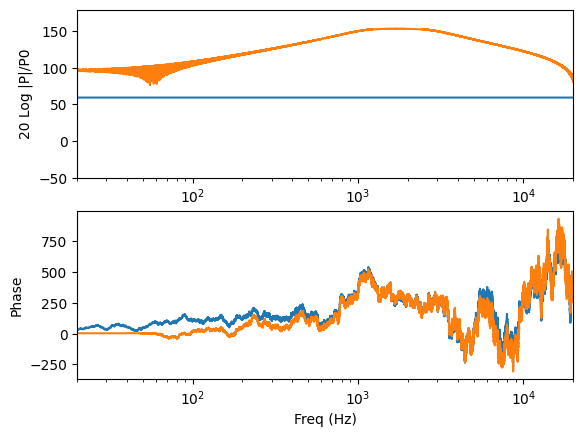

In [7]:
# voltage signal
voltage = mp.Signal.noise(freq_min=0,freq_max=22050,fs=44100,dur=20).similar(unit='V')

# Consider the pressure we have measured is linearly dependent
# on the voltage. In this example we simply create the pressure signal
# by arbitrarly filtering the voltage, an give the resulting signal
# the dimension of Pascals (the similar function is very convenient for that)
pressure = voltage.iir(N=2,Wn=[1000,3000],btype='bandpass',ftype='butter').similar(unit='Pa')

v_fft = voltage.rfft()
p_fft = pressure.rfft()

print("Unit of v_fft is "+str(v_fft.unit))
print("Unit of p_fft is "+str(p_fft.unit))

a=v_fft.plot()
p_fft.plot(ax=a)
a[0].set_xlim([20,20000])
a[0].set_ylim([-50,180])
a[1].set_xlim([20,20000])



The Welch's method implemented in measpy for transfer function estimation preserves units, as illustrated with the command below, which computes the transfer function between voltage and pressure. The resulting spectral data should have the dimension 'Pa/V'.

Pa/V


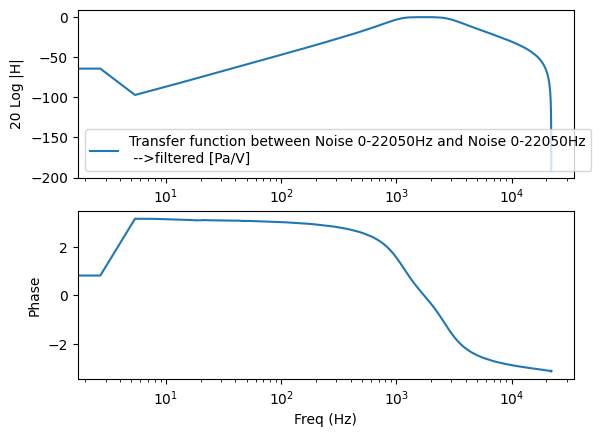

In [8]:
tf=pressure.tfe_welch(voltage,nperseg=2**14)
print(tf.unit)
a=tf.plot()
a[0].legend()

Spectral object can be added, multiplied, divided, etc., provided they have compatible sampling frequency, duration and units.

For instance, it is not allowed to add voltage and pressure spectra. This should raise an Exception.

In [9]:
v_fft+p_fft

Exception: Incompatible units in addition of Spectral obk=jects

It is however possible to multiply them (even if the reason to do this is questionnable...). The units are preserved during the operations

In [10]:
prod = v_fft*p_fft
print(prod.unit)


Pa*V


When going back to time domain, the units are also preserved. For instance, compute the Green's function of our LTI system that transforms voltage to pressure, whose transfer function has already been estimated previously (```tf``` ```Spectral``` object created above).

As it should appear in the plot below, the dimension of the Green's function is now Pa/V

<Axes: xlabel='Time (s)'>

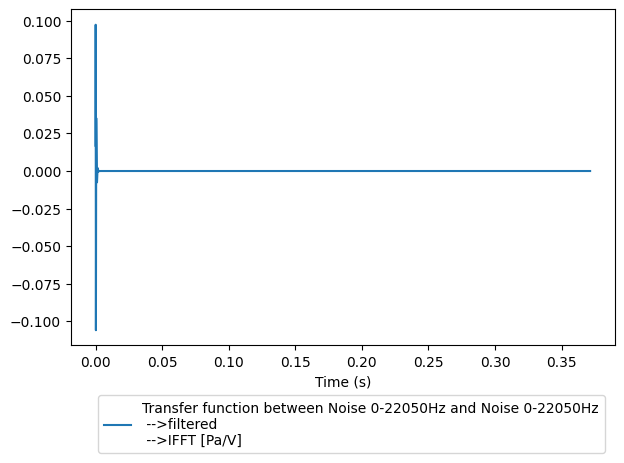

In [11]:
G=tf.irfft()
G.plot()